In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from astropy.io import fits
import IGM
from scipy.integrate import cumtrapz

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

kB = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1, as planck 2018, 67.4 km/s/Mpc
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G
e = 4.80326e-10 # electron charge in esu

z = 2
z2 = (1 + z) / 3
T_CMB *= 1 + z 

T_IGM = 10775.81 # IGM temperature at z = 2 in K

z_reion_He = 3 # redshift that He is fully ionized
z_reion_H = 8 # redshift that H is fully ionized

In [2]:
gamma_e_arr = np.logspace(8, 14, 400) * eV_to_erg / m_e / c**2 # lab-frame Lorentz factor of the electron produced
theta_e_arr = np.logspace(-8,0, 400)

In [11]:
t_arr = [1e8, 1e9, 1e10, 1e11, 1e12, 1e13]
t_num = len(t_arr)

with fits.open('nij_new.fits') as hdul:
    nij = hdul[0].data # shape (t_num, theta, gamma), came from distribution_diff

print(nij.shape)

(6, 400, 400)


In [4]:
print(nij[0][0][0])

4.8511311965430285e-32


In [5]:
d_gamma_e = np.array([gamma_e_arr[i] - gamma_e_arr[i-1] for i in range(1, 400)])
d_gamma_e = np.insert(d_gamma_e, 0, 0)
print(d_gamma_e.shape)

(400,)


In [6]:
n_wt = np.zeros((nij.shape[0], nij.shape[1])) # n_wt(theta) [cm^-3 sr^-1 gamma_e^-1]

for i in range(nij.shape[0]):
    for j in range(nij.shape[1]):
        n_wt[i][j] = np.sum(d_gamma_e / gamma_e_arr * nij[i][j])
        
print(n_wt.shape)

(6, 400)


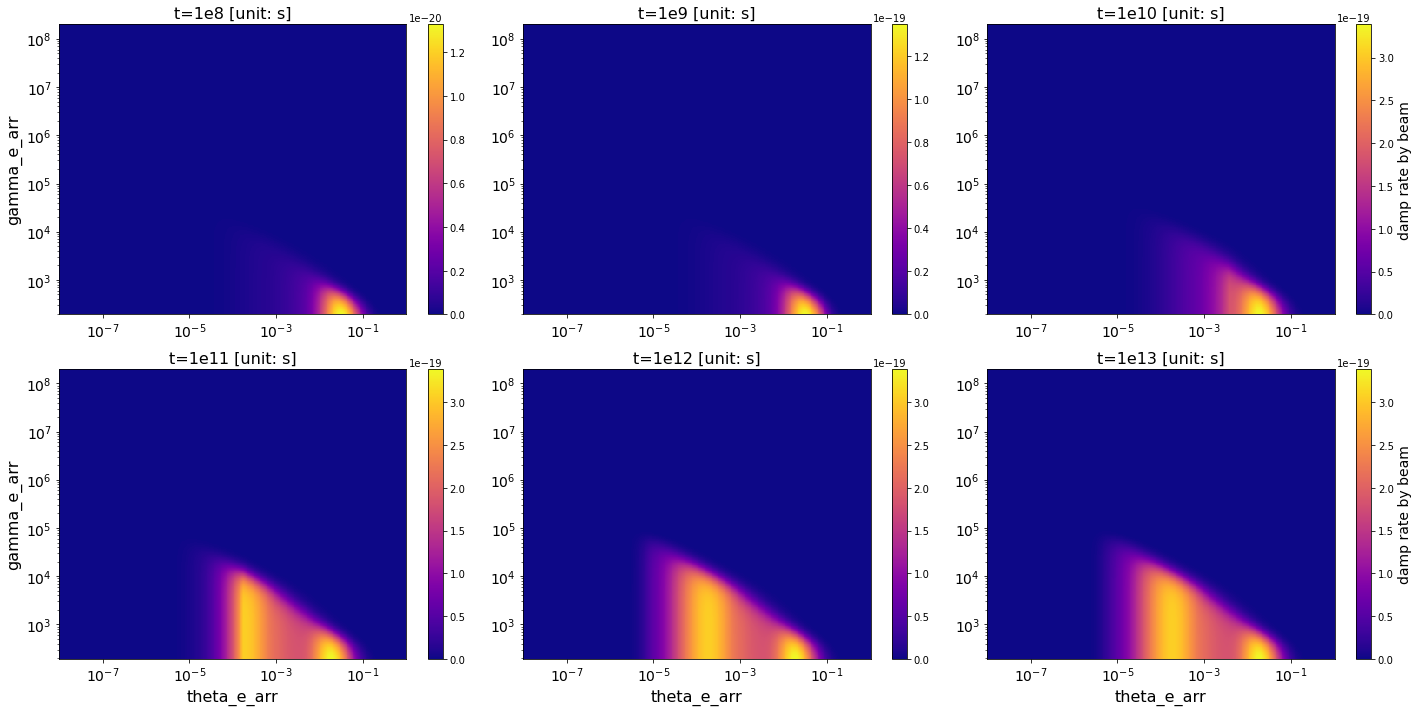

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(theta_e_arr, gamma_e_arr, nij[i], cmap='plasma', shading='auto')
    ax.set_title(f't=1e{i+8} [unit: s]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')
    if i == 3 or i == 4 or i == 5:
        ax.set_xlabel('theta_e_arr', fontsize=16)
    if i == 0 or i == 3:
        ax.set_ylabel('gamma_e_arr', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    cbar = plt.colorbar(im, ax=ax)
    if i == 2 or i == 5:
        cbar.set_label('damp rate by beam', fontsize=14)

plt.tight_layout()
plt.show()

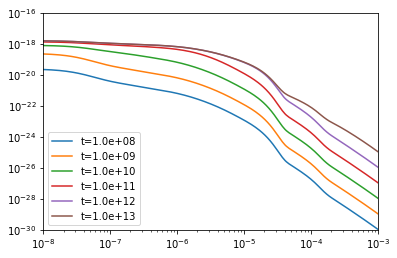

In [32]:
for i in range(t_num):
    plt.plot(theta_e_arr, n_wt[i], label=f't={t_arr[i]:.1e}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-8,1e-3])
plt.ylim([1e-30, 1e-16])
plt.show()

In [7]:
def get_weight(t_num, omega_x): # eq 45
    j_p = np.where(theta_e_arr>abs(omega_x))[0][0]
    
    n_wt_jp1 = n_wt[t_num][j_p+1:]
    n_wt_jp = n_wt[t_num][j_p:-1]
    
    theta_jp1 = theta_e_arr[j_p+1:]
    theta_jp = theta_e_arr[j_p:-1]
    
    sum_ = np.sum((n_wt_jp1 - n_wt_jp) / (theta_jp1 - theta_jp) * (np.arccosh(theta_jp1 / abs(omega_x)) - np.arccosh(theta_jp / abs(omega_x))))
    return 2 * omega_x * sum_

In [14]:
omega_x = np.logspace(-8,-1, 400)
g_p = np.zeros(n_wt.shape)
for i in range(t_num):
    for j in range(g_p.shape[1]):
        g_p[i][j] = get_weight(i, omega_x[j])
print(g_p)

[[-1.62047252e-20 -1.80413153e-20 -1.82742254e-20 ... -2.86925783e-39
  -2.00080705e-39 -1.36752916e-39]
 [-1.60341722e-19 -1.78142762e-19 -1.80773872e-19 ... -2.86925864e-38
  -2.00080761e-38 -1.36752953e-38]
 [-3.49307515e-19 -3.82168449e-19 -3.91166459e-19 ... -2.86926700e-37
  -2.00081316e-37 -1.36753350e-37]
 [-3.61767190e-19 -3.95166828e-19 -4.04699869e-19 ... -2.86935266e-36
  -2.00086823e-36 -1.36757589e-36]
 [-3.62949938e-19 -3.96398626e-19 -4.05982457e-19 ... -2.87019647e-35
  -2.00142189e-35 -1.36798353e-35]
 [-3.62955558e-19 -3.96404477e-19 -4.05988551e-19 ... -2.87569127e-34
  -2.00765622e-34 -1.37151550e-34]]


In [16]:
g = np.zeros(n_wt.shape)
for i in range(t_num): # eq 52
    g[i] = cumtrapz(g_p[i], omega_x, initial=0) # integrate dg/d\omega_x with omega_x with initial 0
    print(f't={t_arr[i]:.1e}, max g={np.max(abs(g[i]))}')

t=1.0e+08, max g=4.8558683883508185e-27
t=1.0e+09, max g=4.8692370426560765e-26
t=1.0e+10, max g=4.024833990882094e-25
t=1.0e+11, max g=2.3148321360401634e-24
t=1.0e+12, max g=4.7529235086684735e-24
t=1.0e+13, max g=4.8828350415764856e-24


/var/folders/k2/qxng019s7y17hp_kgkzy9b180000gn/T/ipykernel_97429/3938335685.py:3: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  g[i] = cumtrapz(g_p[i], omega_x, initial=0) # integrate dg/d\omega_x with omega_x with initial 0


In [24]:
G_x_max = np.zeros((t_num, ))
for i in range(t_num):
    G_x_max[i] = np.max(np.abs(g[i]))
    
print(G_x_max)

[4.85586839e-27 4.86923704e-26 4.02483399e-25 2.31483214e-24
 4.75292351e-24 4.88283504e-24]


## Ignore below

In [32]:
IGM_00 = IGM.IGM_N(0, 0)
N, P_e, P_eV = IGM_00.get_P()

In [34]:
print(N)

[[ 0.00000000e+00 -7.93132022e-13 -1.32871075e-12 ...  1.87216170e-06
   1.82058987e-06  1.76949969e-06]
 [ 0.00000000e+00 -8.48788734e-13 -1.42180407e-12 ...  1.84560465e-06
   1.79478791e-06  1.74444440e-06]
 [ 0.00000000e+00 -9.09067129e-13 -1.52262720e-12 ...  1.81983703e-06
   1.76975260e-06  1.72013323e-06]
 ...
 [ 0.00000000e+00  1.32144308e-29  1.98528833e-29 ...  7.23761685e-20
   7.05912659e-20  6.87560620e-20]
 [ 0.00000000e+00  7.65967535e-30  1.15054140e-29 ...  4.21587269e-20
   4.10868261e-20  3.99935757e-20]
 [ 0.00000000e+00  3.33432792e-30  5.00748266e-30 ...  1.84287129e-20
   1.79472873e-20  1.74603478e-20]]


In [33]:
print(np.max(N))

3.0945676892631237e-05


In [4]:
d_gamma_e = np.array([gamma_e_arr[i] - gamma_e_arr[i-1] for i in range(1, 400)])
d_gamma_e = np.insert(d_gamma_e, 0, 0)
print(d_gamma_e.shape)

(400,)


In [5]:
n_wt = np.zeros((nij.shape[0], nij.shape[1])) # indices (time, theta)

for i in range(nij.shape[0]):
    for j in range(nij.shape[1]):
        n_wt[i][j] = np.sum(d_gamma_e / gamma_e_arr * nij[i][j])
        
print(n_wt.shape)

(6, 400)


In [6]:
omega_x = np.logspace(-8,-1, 400)

In [7]:
omega_y = np.zeros((len(theta_e_arr), len(omega_x))) #[i] theta, [j] omega_x, theta^2 = omega_x^2 + omega_y^2
for i in range(len(theta_e_arr)):
    for j in range(len(omega_x)):
        if theta_e_arr[i] > omega_x[j]:
            omega_y[i][j] = np.sqrt(theta_e_arr[i]**2 - omega_x[j]**2)

In [8]:
print(omega_y)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.11016610e-09 1.12184948e-09 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.50354986e-09 3.44490558e-09 1.65672413e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.11800339e-01 9.11800339e-01 9.11800339e-01 ... 9.07122878e-01
  9.06728188e-01 9.06300093e-01]
 [9.54882369e-01 9.54882369e-01 9.54882369e-01 ... 9.50416959e-01
  9.50040256e-01 9.49631686e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 9.95736942e-01
  9.95377390e-01 9.94987437e-01]]


In [9]:
d_omega_y = np.zeros(omega_y.shape)
for i in range(omega_y.shape[0]):
    d_omega_y_i = np.array([omega_y[i][j] - omega_y[i][j-1] for j in range(1, omega_y.shape[1])])
    d_omega_y[i] = np.insert(d_omega_y_i, 0, 0)

In [10]:
print(d_omega_y)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.98831661e-09 -1.12184948e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.05864428e-09 -1.78818145e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.63903660e-04
  -3.94689649e-04 -4.28095341e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.47333057e-04
  -3.76703161e-04 -4.08569998e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.31529923e-04
  -3.59551548e-04 -3.89953113e-04]]


In [11]:
# G_x = np.zeros((len(t_arr), len(theta_e_arr))) # g(omega_x) = int_-int^int theta_wt domega_y?
# for i in range(len(t_arr)):
#     for j in range(len(theta_e_arr)):
#         G_x[i][j] = np.sum(n_wt[i][j] * d_omega_y[j])

In [40]:
G_x = np.zeros((len(t_arr), len(theta_e_arr))) # g(omega_x) = int_-int^int theta_wt domega_y?
for i in range(len(t_arr)):
    for j in range(len(theta_e_arr)):
        G_x[i][j] = np.sum(n_wt[i,:] * d_omega_y[:,j])*2

In [41]:
G_x_max = np.zeros((len(t_arr), ))
for i in range(len(t_arr)):
    G_x_max[i] = np.max(np.abs(G_x[i]))
    
print(G_x_max)

[1.05664249e-27 1.05733951e-26 1.06299072e-25 8.01784826e-25
 1.55146862e-24 1.57188903e-24]


## Ignore above

In [ ]:
## I use eq2 in https://arxiv.org/pdf/astro-ph/9706219 to calculate Jeans scale, but I have many questions

In [17]:
a_t = 1 / (1 + z)
print(a_t)
omega_m = 0.315
omega_lambda = 1 - 0.315
H_2 = H_0 * np.sqrt(omega_m * (1 + z)**3 + omega_lambda)
print(H_2)
rho_2 = rho_crit * H_2**2 / H_0**2 # is defined as the average mass density of the universe, I use critc density
print(rho_2)

0.3333333333333333
6.620798791686696e-18
7.839645969510394e-29


In [18]:
# c_s is defined as c_s^2 == dP/drho in https://arxiv.org/pdf/astro-ph/9706219 section 3 after eq.1
# but I'm not sure what how to calculate dP and d rho, so I try to use sqrt(gamma*P/rho), not sure if it's right

P_th = 1.0194130441629218e-05*1.602e-12 # thermal pressure at z = 2 at mean density from temp_history.py and result.ipynb
adiabatic_index = 5/3 #suppose
c_s = np.sqrt(adiabatic_index * P_th / rho_2) # speed of sound in the cosmic gas
print(c_s)

589226.8090835003


In [19]:
k_J = a_t / c_s * np.sqrt(4 * np.pi * G * rho_2) # Jeans scale wavenumber
print(k_J)

4.587248486564138e-24


In [20]:
1/k_J
#1.4e10 pc = 4.32e28 cm

2.1799560301321342e+23

In [22]:
omega_b = omega_b_0 * (1 + z)**3
mean_n_b = 3 * omega_b * H_0 * H_0 / (8 * np.pi * G * m_p) # mean number density of baryons at the redshift
n_b = mean_n_b
    
n_H = n_b * (1 - Y_He) # nuclei in hydrogen
n_He = n_H * f_He # nuclei in helium, assume He is all 4He

if z <= z_reion_He: # fully ionized
    n_e = n_H + 2 * n_He
if z_reion_He < z <= z_reion_H: # He is singly ionized
    n_e = n_H + n_He
if z > z_reion_H: # neutral
    n_e = 0
    
omega_p = (4 * np.pi * r0 * n_e)**0.5 * c

print(z, omega_p, n_e)

2 137.9303486045721 5.977306940756935e-06


In [23]:
N_fold = 1

In [27]:
for i in range(len(t_arr)): # eq 56
    angle = 2 * N_fold * c * n_e / (np.pi * omega_p * np.abs(1 / k_J) * (G_x_max[i]))
    print(f't={t_arr[i]:.1e}, angle={angle}')
    theta_min = np.arcsin(angle) / 2
    print(theta_min)
    
print(n_e, omega_p, 1/k_J, np.max(G_x_max))
# print(angle)
# theta_min = np.arcsin(angle) / 2
# print(theta_min)

t=1.0e+08, angle=781344.9944983729
nan
t=1.0e+09, angle=77919.97854988753
nan
t=1.0e+10, angle=9426.74522173091
nan
t=1.0e+11, angle=1639.0425897884475
nan
t=1.0e+12, angle=798.2683609910879
nan
t=1.0e+13, angle=777.029825270488
nan
5.977306940756935e-06 137.9303486045721 2.1799560301321342e+23 4.8828350415764856e-24


/var/folders/k2/qxng019s7y17hp_kgkzy9b180000gn/T/ipykernel_97429/3973869490.py:4: RuntimeWarning: invalid value encountered in arcsin
  theta_min = np.arcsin(angle) / 2
